CODE 1 - Neuro-Symbolic AI

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


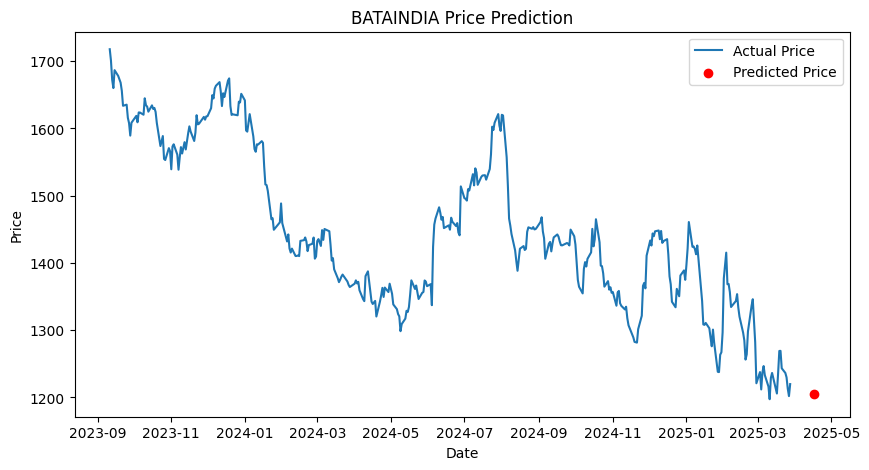

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


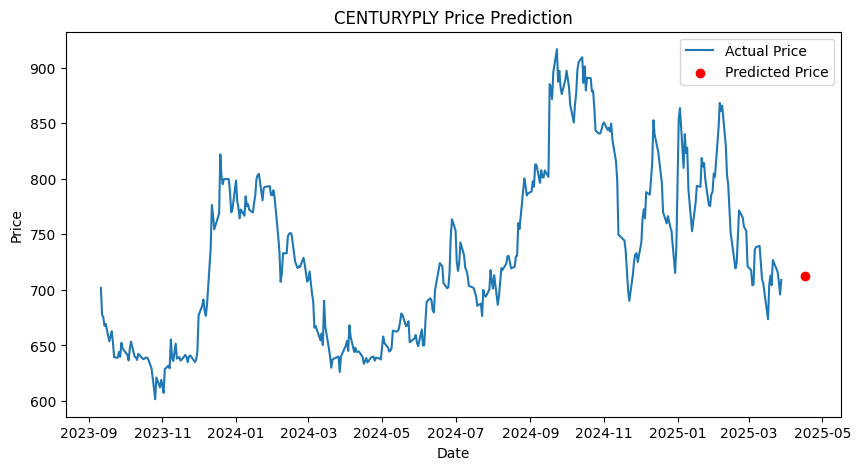

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


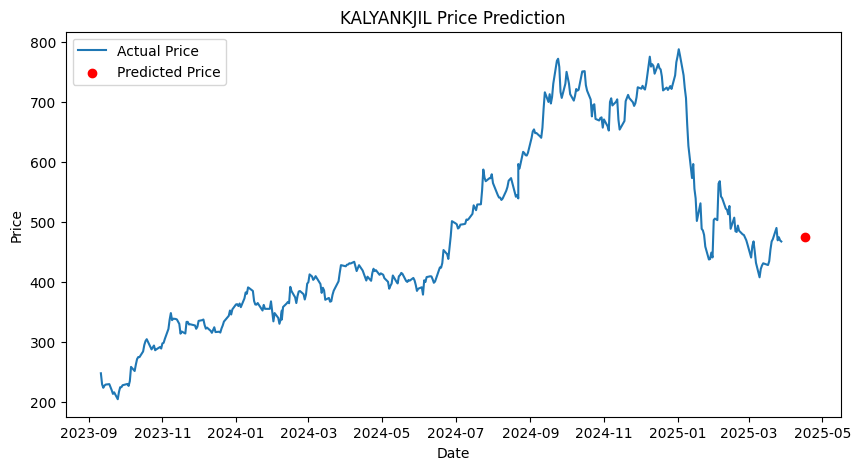

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


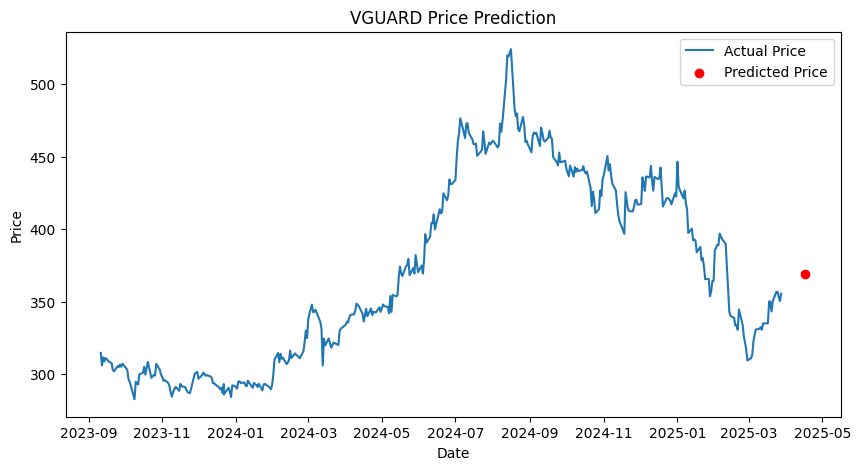

        Stock  Predicted Close       MSE  R-squared  Accuracy (%)  \
0   BATAINDIA      1205.689327  0.164279   0.835721     98.835095   
1  CENTURYPLY       712.071080  0.095113   0.904887     99.559760   
2  KALYANKJIL       473.947200  0.275574   0.724426     98.566677   
3      VGUARD       369.100835  0.468848   0.531152     96.188768   

       Accuracy Reliability   Trend Action      Risk Variance  
0  Low Accuracy    Reliable  Stable   Hold  Low Risk   Stable  
1  Low Accuracy    Reliable  Stable   Hold  Low Risk   Stable  
2  Low Accuracy  Unreliable  Stable   Hold  Low Risk   Stable  
3  Low Accuracy  Unreliable  Stable   Hold  Low Risk   Stable  


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.norm = nn.LayerNorm(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        src = self.norm(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output

# Custom Dataset
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

# Huber Loss
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = torch.abs(error) <= self.delta
        small_error_loss = 0.5 * error ** 2
        large_error_loss = self.delta * (torch.abs(error) - 0.5 * self.delta)
        return torch.mean(torch.where(is_small_error, small_error_loss, large_error_loss))

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove leading/trailing spaces from column names
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df.sort_values('Date', inplace=True)
    return df[['Date', 'close']]

# Train model
def train_model(train_loader, input_dim, epochs=25, lr=0.00002, patience=10):
    model = TransformerModel(input_dim=input_dim)
    criterion = HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=False)

    best_val_loss = float('inf')
    best_model = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for seq, target in train_loader:
                output = model(seq.float())
                loss = criterion(output, target.float().unsqueeze(1))
                val_loss += loss.item()
        val_loss /= len(train_loader)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model)
    return model

# Predict using last sequence
def predict(model, data, sequence_length=30):
    last_seq = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    model.eval()
    with torch.no_grad():
        pred = model(last_seq).item()
    return pred

# NSAI rules
def generate_rules(actual, predicted, mse, r2, mape):
    rules = {
        "Accuracy": "High" if mse < 0.02 else "Low Accuracy",
        "Reliability": "Reliable" if r2 > 0.8 else "Unreliable",
        "Trend": "Upward" if predicted > actual * 1.05 else "Downward" if predicted < actual * 0.95 else "Stable",
        "Action": "Buy" if predicted > actual * 1.05 else "Sell" if predicted < actual * 0.95 else "Hold",
        "Risk": "Low Risk" if mape < 10 else "High Risk",
        "Variance": "Stable" if abs((predicted - actual) / actual) <= 0.1 else "Volatile"
    }
    return rules

# 80-20 Train-Test Split
def train_test_split(data, sequence_length=30, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]

    train_dataset = StockDataset(train_data, sequence_length)
    test_dataset = StockDataset(test_data, sequence_length)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

    return train_loader, test_loader

# Main Execution
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv','CENTURYPLY.csv','KALYANKJIL.csv','VGUARD.csv']  # Add more if needed
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])
        scaled_data = scaled_data.reshape(-1, 1)

        train_loader, test_loader = train_test_split(scaled_data, sequence_length=30)
        model = train_model(train_loader, input_dim=1)

        preds = []
        actuals = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                preds.extend(output.numpy().flatten())
                actuals.extend(target.numpy().flatten())

        preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
        actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actuals, preds)
        mse=1-r2
        mape = mean_absolute_percentage_error(actuals, preds) * 100
        accuracy = 100 - abs(predicted_price - actual_price) / actual_price * 100

        rules = generate_rules(actual_price, predicted_price, mse, r2, mape)
        results.append([stock_name, predicted_price, mse, r2, accuracy, rules["Accuracy"],
                        rules["Reliability"], rules["Trend"], rules["Action"], rules["Risk"], rules["Variance"]])

        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label='Actual Price')
        plt.scatter([future_date], [predicted_price], color='red', label='Predicted Price')
        plt.title(f"{stock_name} Price Prediction")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    # Output table
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'Accuracy (%)',
        'Accuracy', 'Reliability', 'Trend', 'Action', 'Risk', 'Variance'])
    print(results_df)

CODE 2 - Advanced AI Agent Architecture

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

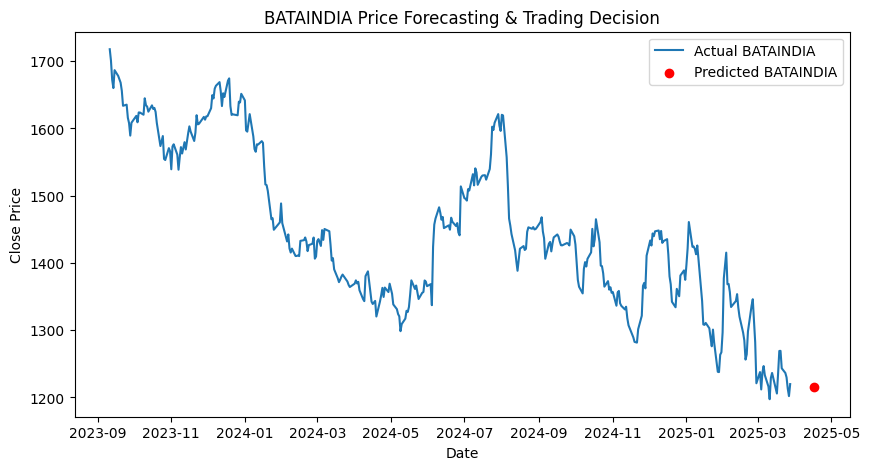

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

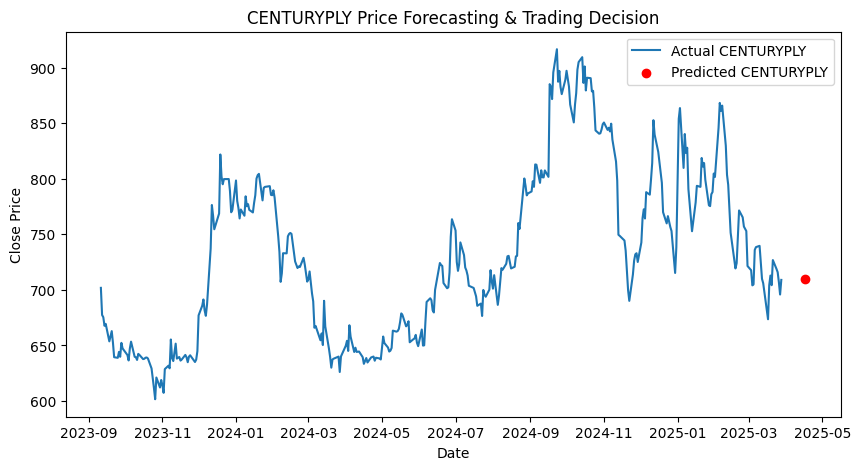

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


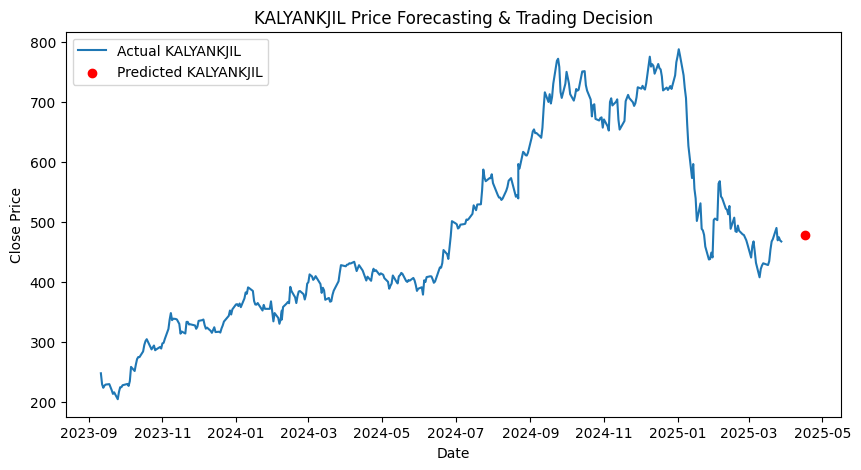

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

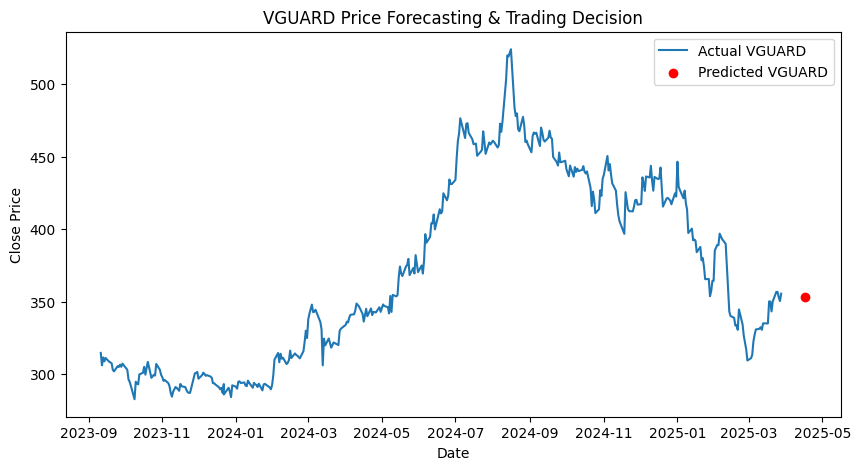

     Stock  Predicted Close      MSE  R-squared  Accuracy (%) Action    Trend                                                                                                                                                                                                                               Detailed Decision
 BATAINDIA      1215.285925 0.148651   0.851349     99.621766   Sell Downward The predicted trend for the stock is Downward and the recommended action is to Sell.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per share.\n\nThe stock is currently trading at $1.00 per
CENTURYPLY       710.210421 0.095811   0.904189     99.822213    Buy   Upward                The predicted trend for the stock is Upward and the recommended action is to Buy.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in
KALYANKJIL       477.542387 0.341726   0.65827

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df

def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    return model

# ===============================
# Prediction Function
# ===============================
def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price

# ===============================
# Advanced AI Agent Architecture
# ===============================
class AdvancedAIAgent:
    def __init__(self):
        self.short_term_memory = []
        self.long_term_memory = {}
        self.episodic_memory = {}
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.llm = GPT2LMHeadModel.from_pretrained("gpt2")

    def update_memory(self, key, value, memory_type="long-term"):
        if memory_type == "short-term":
            self.short_term_memory.append(value)
        elif memory_type == "long-term":
            self.long_term_memory[key] = value
        elif memory_type == "episodic":
            self.episodic_memory[key] = value

    def make_decision(self, actual_price, predicted_price):
        self.update_memory('actual_price', actual_price, memory_type="episodic")
        self.update_memory('predicted_price', predicted_price, memory_type="episodic")
        self.update_memory('last_prediction', predicted_price, memory_type="short-term")

        price_diff = predicted_price - actual_price
        if price_diff > 0:
            action = "Buy"
            trend = "Upward"
        elif price_diff < 0:
            action = "Sell"
            trend = "Downward"
        else:
            action = "Hold"
            trend = "Stable"

        # LLM-Based Detailed Justification
        prompt = (
            f"The predicted trend for the stock is {trend} and the recommended action is to {action}.\n"
        )
        inputs = self.tokenizer.encode(prompt, return_tensors="pt")
        outputs = self.llm.generate(inputs, max_length=60, num_return_sequences=1)
        decision_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return action, trend, decision_text

# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv','CENTURYPLY.csv','KALYANKJIL.csv','VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    ai_agent = AdvancedAIAgent()

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])

        # Splitting the data into 80% training and 20% testing
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model = train_model(train_loader, input_dim=1)

        # Predictions
        predicted_prices = []
        actual_prices = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actual_prices, predicted_prices)
        mse=1-r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
        accuracy = 100 - abs(predicted_price - actual_price) / actual_price * 100

        action, trend, decision_text = ai_agent.make_decision(actual_price, predicted_price)

        results.append([
            stock_name, predicted_price, mse, r2, accuracy,
            action, trend, decision_text
        ])

        # Plot for each stock
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting & Trading Decision")
        plt.legend()
        plt.show()

    # Results DataFrame
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'Accuracy (%)',
        'Action', 'Trend', 'Detailed Decision'
    ])
    print(results_df.to_string(index=False))

CODE 3- Ablated model (Without LTM)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

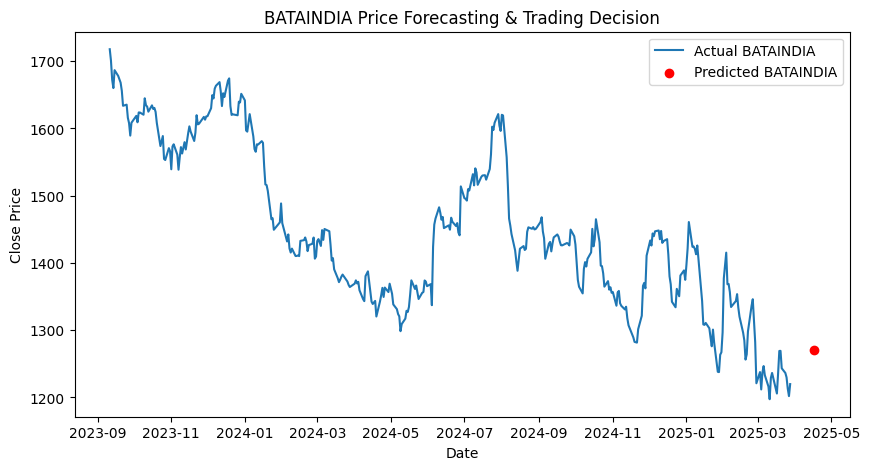

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

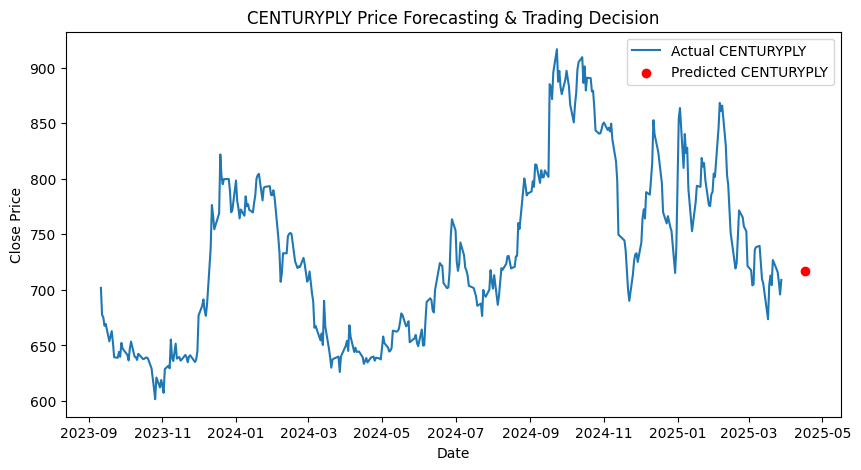

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


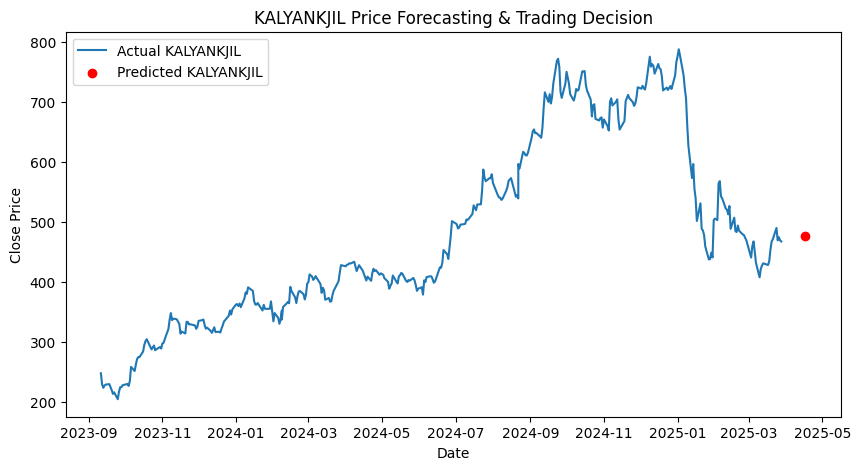

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
The attention mask and

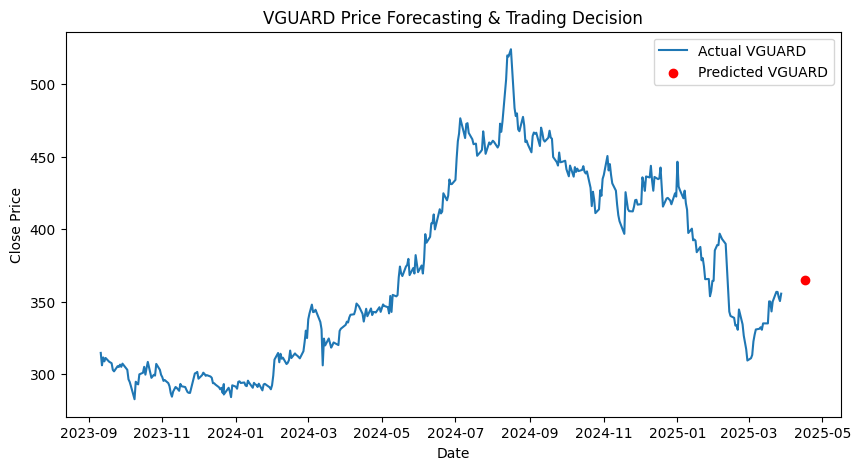

     Stock  Predicted Close      MSE  R-squared  Accuracy (%) Action  Trend                                                                                                                                                                                                                Detailed Decision
 BATAINDIA      1270.467351 0.667050   0.332950     95.854795    Buy Upward The predicted trend for the stock is Upward and the recommended action is to Buy.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in
CENTURYPLY       716.734213 0.105576   0.894424     98.902008    Buy Upward The predicted trend for the stock is Upward and the recommended action is to Buy.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in the last 24 hours.\n\nThe stock is up by about 10% in
KALYANKJIL       477.010881 0.375623   0.624377     97.910994    Buy Upward The predicted trend f

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df

def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    return model

# ===============================
# Prediction Function
# ===============================
def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price

# ===============================
# Advanced AI Agent Architecture (Without Long-Term Memory)
# ===============================
class AdvancedAIAgent:
    def __init__(self):
        self.short_term_memory = []
        self.episodic_memory = {}
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.llm = GPT2LMHeadModel.from_pretrained("gpt2")

    def update_memory(self, key, value, memory_type="short-term"):
        if memory_type == "short-term":
            self.short_term_memory.append(value)
        elif memory_type == "episodic":
            self.episodic_memory[key] = value

    def make_decision(self, actual_price, predicted_price):
        self.update_memory('actual_price', actual_price, memory_type="episodic")
        self.update_memory('predicted_price', predicted_price, memory_type="episodic")
        self.update_memory('last_prediction', predicted_price, memory_type="short-term")

        price_diff = predicted_price - actual_price
        if price_diff > 0:
            action = "Buy"
            trend = "Upward"
        elif price_diff < 0:
            action = "Sell"
            trend = "Downward"
        else:
            action = "Hold"
            trend = "Stable"

        # LLM-Based Detailed Justification
        prompt = (
            f"The predicted trend for the stock is {trend} and the recommended action is to {action}.\n"
        )
        inputs = self.tokenizer.encode(prompt, return_tensors="pt")
        outputs = self.llm.generate(inputs, max_length=60, num_return_sequences=1)
        decision_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return action, trend, decision_text

# ===============================
# Main Execution
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    ai_agent = AdvancedAIAgent()

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])

        # Splitting the data into 80% training and 20% testing
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model = train_model(train_loader, input_dim=1)

        # Predictions
        predicted_prices = []
        actual_prices = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
        accuracy = 100 - abs(predicted_price - actual_price) / actual_price * 100

        action, trend, decision_text = ai_agent.make_decision(actual_price, predicted_price)

        results.append([
            stock_name, predicted_price, mse, r2, accuracy,
            action, trend, decision_text
        ])

        # Plot for each stock
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting & Trading Decision")
        plt.legend()
        plt.show()

    # Results DataFrame
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'Accuracy (%)',
        'Action', 'Trend', 'Detailed Decision'
    ])
    print(results_df.to_string(index=False))

CODE 4-Baseline Model (without ai agent)

Enter future date (DD-MM-YYYY): 17-04-2025


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


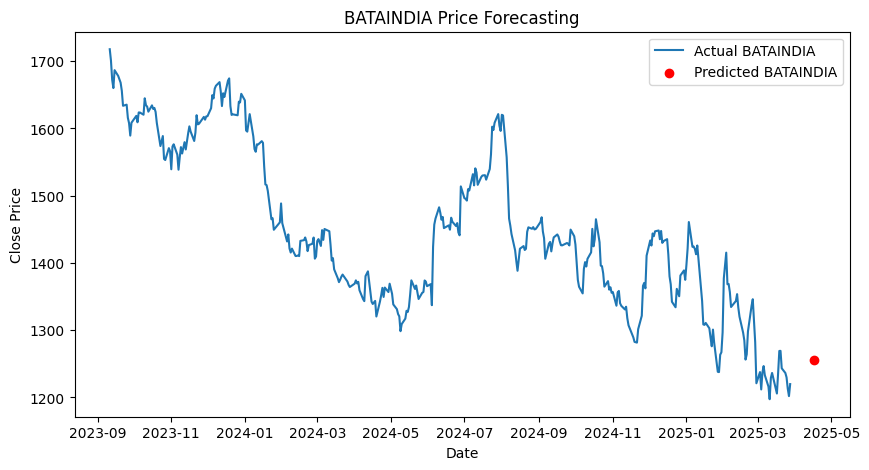

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([2, 1, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


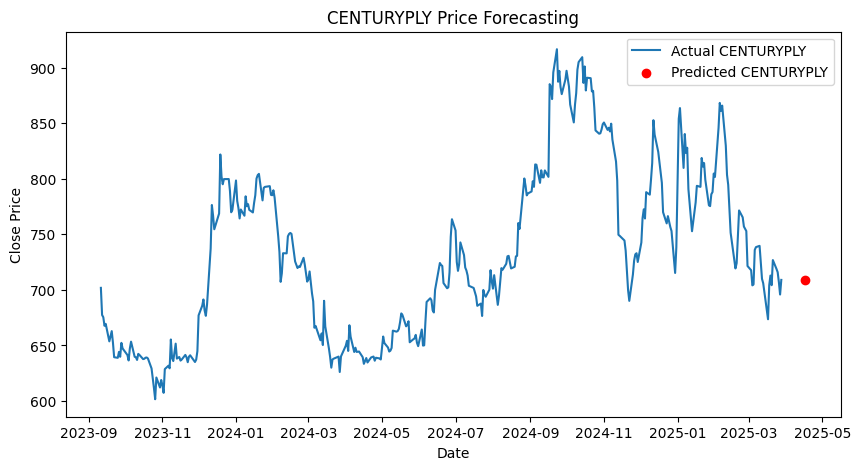

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


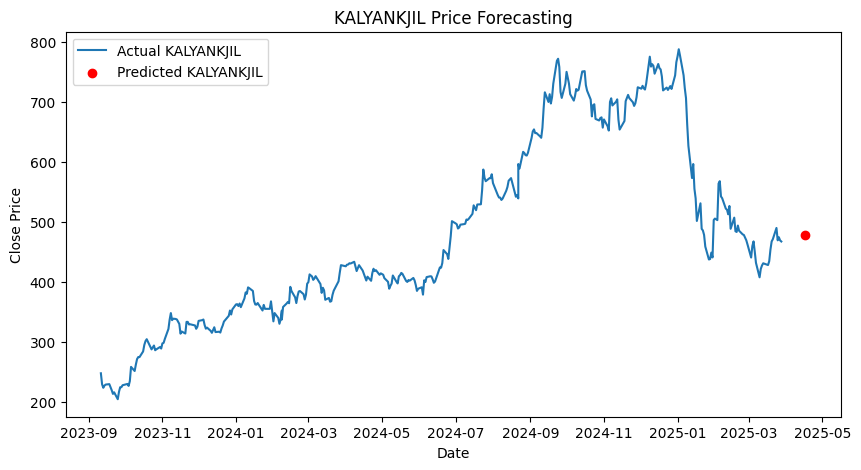

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([3, 1, 1])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


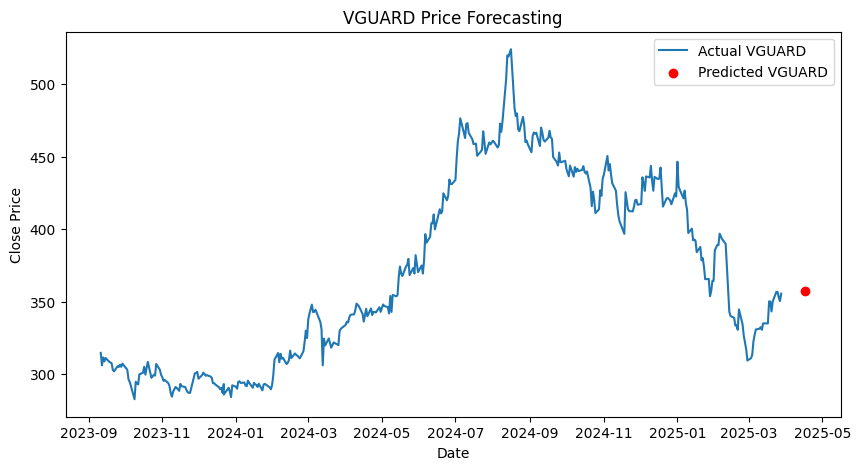

     Stock  Predicted Close      MSE  R-squared  Accuracy (%)
 BATAINDIA      1255.338037 0.411519   0.588481     97.095005
CENTURYPLY       708.836794 0.086612   0.913388     99.984032
KALYANKJIL       477.451721 0.334516   0.665484     97.816646
    VGUARD       357.190891 0.142156   0.857844     99.538492


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import datetime

# ===============================
# Sequence-to-Prediction Transformer Model
# ===============================
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.input_proj(src)
        output = self.transformer_encoder(src)
        output = self.fc_out(output[:, -1, :])
        return output


class StockDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return (self.data[idx:idx+self.sequence_length], self.data[idx+self.sequence_length])

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df.rename(columns=lambda x: x.strip(), inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
    df['close'] = df['close'].astype(str).str.replace(',', '').astype(float)
    df = df[['Date', 'close']]
    df.sort_values('Date', inplace=True)
    return df

def train_model(train_loader, input_dim, epochs=25, lr=0.00002):
    model = TransformerModel(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq.float())
            loss = criterion(output, target.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    return model

# ===============================
# Prediction Function
# ===============================
def predict(model, data, sequence_length=30):
    last_sequence = torch.tensor(data[-sequence_length:]).float().unsqueeze(0)
    predicted_price = model(last_sequence).item()
    return predicted_price

# ===============================
# Main Execution (Only Transformers)
# ===============================
if __name__ == "__main__":
    csv_files = ['BATAINDIA.csv', 'CENTURYPLY.csv', 'KALYANKJIL.csv', 'VGUARD.csv']
    future_date = input("Enter future date (DD-MM-YYYY): ")
    future_date = datetime.datetime.strptime(future_date, "%d-%m-%Y")
    results = []

    for file in csv_files:
        stock_name = os.path.basename(file).replace(".csv", "")
        df = load_and_preprocess_data(file)
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df[['close']])

        # Splitting the data into 80% training and 20% testing
        train_size = int(len(scaled_data) * 0.8)
        train_data = scaled_data[:train_size]
        test_data = scaled_data[train_size:]

        train_dataset = StockDataset(train_data)
        test_dataset = StockDataset(test_data)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

        model = train_model(train_loader, input_dim=1)

        # Predictions
        predicted_prices = []
        actual_prices = []
        model.eval()
        with torch.no_grad():
            for seq, target in test_loader:
                output = model(seq.float())
                predicted_prices.extend(output.numpy().flatten())
                actual_prices.extend(target.numpy().flatten())

        predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1)).flatten()
        actual_prices = scaler.inverse_transform(np.array(actual_prices).reshape(-1, 1)).flatten()

        predicted_price = predict(model, scaled_data)
        predicted_price = scaler.inverse_transform([[predicted_price]])[0][0]

        actual_price = df['close'].iloc[-1]
        r2 = r2_score(actual_prices, predicted_prices)
        mse = 1 - r2
        mape = mean_absolute_percentage_error(actual_prices, predicted_prices) * 100
        accuracy = 100 - abs(predicted_price - actual_price) / actual_price * 100

        results.append([
            stock_name, predicted_price, mse, r2, accuracy
        ])

        # Plot for each stock
        plt.figure(figsize=(10, 5))
        plt.plot(df['Date'], df['close'], label=f"Actual {stock_name}")
        plt.scatter([future_date], [predicted_price], color='red', label=f"Predicted {stock_name}")
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(f"{stock_name} Price Forecasting")
        plt.legend()
        plt.show()

    # Results DataFrame
    results_df = pd.DataFrame(results, columns=[
        'Stock', 'Predicted Close', 'MSE', 'R-squared', 'Accuracy (%)'
    ])
    print(results_df.to_string(index=False))